In [1]:
#Data prep;   
import pandas as pd      
pd.options.display.max_columns = None    

#(1) data prep;    
import sqlite3      
conn = sqlite3.connect('flights.sqlite')   

airlines = pd.read_sql_query("SELECT * FROM airlines", conn)
airports = pd.read_sql_query("SELECT * FROM airports", conn)
ny_flights = pd.read_sql_query("SELECT * FROM ny_flights", conn)    
cities = pd.read_sql_query("SELECT * FROM cities", conn)

print('airlines, rows, columns, missings:', len(airlines), len(airlines.columns), airlines.isnull().sum().sum())
print('airports, rows, columns, missings:', len(airports), len(airports.columns), airports.isnull().sum().sum())
print('ny_flights, rows, columns, missings:', len(ny_flights), len(ny_flights.columns), ny_flights.isnull().sum().sum())
print('cities, rows, columns, missings:', len(cities), len(cities.columns), cities.isnull().sum().sum())  

airlines, rows, columns, missings: 1665 3 0
airports, rows, columns, missings: 6520 3 1
ny_flights, rows, columns, missings: 825413 23 218880
cities, rows, columns, missings: 5898 2 0


In [2]:
ny_flights.isnull()

,fl_date,op_carrier_airline_id,op_carrier_fl_num,origin_airport_id,origin_city_market_id,dest_airport_id,dest_city_market_id,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance
0,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,True,True,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825408,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
825409,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
825410,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
825411,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [2]:
#(1-2) Extract airport IDs;
'''
LA airports: LAX, SNA, BUR, LGB
SF airports: SFO, SJC, OAK
NY airports: LGA, JFK, EWR
'''  
print(airports.loc[(airports['location'].str.contains('CA')) & (airports['airport_name'].str.contains('Los Angeles')), :])
print(airports.loc[(airports['location'].str.contains('CA')) & (airports['airport_name'].str.contains('San Francisco')), :])
print(airports.loc[(airports['location'].str.contains('IL')) & (airports['airport_name'].str.contains('Chicago')), :])

print(airports.loc[(airports['location'].str.contains('NJ')) & (airports['airport_name'].str.contains('Newark')), :])
print(airports.loc[(airports['location'].str.contains('NY')) & (airports['airport_name'].str.contains('Kennedy')), :])
print(airports.loc[(airports['location'].str.contains('NY')) & (airports['airport_name'].str.contains('LaGuardia')), :])

           id         location               airport_name
2765  12892.0  Los Angeles, CA  Los Angeles International
           id           location                 airport_name
4549  14771.0  San Francisco, CA  San Francisco International
           id      location                    airport_name
951   10986.0   Chicago, IL       Chicago Metropolitan Area
3098  13232.0   Chicago, IL    Chicago Midway International
3770  13930.0   Chicago, IL    Chicago O'Hare International
4151  14320.0   Chicago, IL               Chicago Executive
4295  14512.0  Rockford, IL  Chicago/Rockford International
           id    location                  airport_name
1552  11618.0  Newark, NJ  Newark Liberty International
           id      location                   airport_name
2381  12478.0  New York, NY  John F. Kennedy International
           id      location airport_name
2824  12953.0  New York, NY    LaGuardia


In [6]:
##Convert to CSV; 
# ny_flights.to_csv('ny_flights.csv', index=False)
# airlines.to_csv('airlines.csv', index=False)  

In [3]:
#(1-3) clean & add features to to ny_flight;  
#filter;
ny_flights=ny_flights.loc[(ny_flights['cancelled']==0) & (ny_flights['diverted']==0), :]

#city names;
cities.drop_duplicates(inplace=True)    
cities_dic=dict(zip(cities.id, cities.city))  
ny_flights['origin_city_market']=ny_flights['origin_city_market_id'].apply(lambda x: cities_dic[x])
ny_flights['dest_city_market']=ny_flights['dest_city_market_id'].apply(lambda x: cities_dic[x])  

#airline names;
airlines_dic=dict(zip(airlines.id, airlines.airline_name))  
ny_flights['op_carrier_airline_nm']=ny_flights['op_carrier_airline_id'].apply(lambda x: airlines_dic[x])

#airport names;
airports_dic=dict(zip(airports.id, airports.airport_name))
ny_flights['origin_airport_nm']=ny_flights['origin_airport_id'].apply(lambda x: airports_dic[x])
ny_flights['dest_airport_nm']=ny_flights['dest_airport_id'].apply(lambda x: airports_dic[x])

#date features;    
import time
import datetime
ny_flights['fl_wkday']=ny_flights['fl_date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").weekday())

date_dic={0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
ny_flights['fl_weekday']=ny_flights['fl_wkday'].apply(lambda x: date_dic[x])
ny_flights.drop('fl_wkday', axis=1, inplace=True)

ny_flights['fl_yr']=ny_flights['fl_date'].apply(lambda x: x.split('-')[0])
ny_flights['fl_mon']=ny_flights['fl_date'].apply(lambda x: x.split('-')[1])      

In [4]:
##Question 1;  
#(2) Define the route:  
orig_arpts=[12953, 12478, 11618]  
dest_arpts=[13930]    

routes=ny_flights.loc[(ny_flights['origin_airport_id'].isin(orig_arpts)) & (ny_flights['dest_airport_id'].isin(dest_arpts))]
print(routes['origin_airport_id'].value_counts())
'''
Only Chicago O'Hare airport found routes with flights from 2 NY airports.
Other destination airports such as LAX or SFO found flights from only 1 NY airport.
Due to data limitation, will focus on NY-> O'Hare.   
'''

12953.0    15932
12478.0     3055
Name: origin_airport_id, dtype: int64


"\nOnly Chicago O'Hare airport found routes with flights from 2 NY airports.\nOther destination airports such as LAX or SFO found flights from only 1 NY airport.\nDue to data limitation, will focus on NY-> O'Hare.   \n"

In [5]:
routes['fl_yr'].value_counts()
#2019 data understandably not fully ready, will focus on 2018 for Question 1's exploratory analysis;     

2018    10285
2019     8702
Name: fl_yr, dtype: int64

In [6]:
#remove dups; 
routes=routes.loc[routes['fl_yr']=='2018']  
routes.drop_duplicates(inplace=True)  

#insuficient data (only 7 month in 2018);
routes['fl_mon'].value_counts()  
#In this route: only 2nd half year data in 2018 available. 

10    1569
08    1509
06    1509
07    1490
09    1462
11    1396
12    1350
Name: fl_mon, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


Text(0.5, 1.0, 'Flight Volumne Distribution, by Weekday')

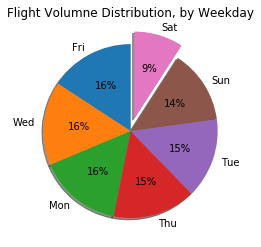

In [7]:
#(2-1) How busy is this route? Are there more flights on some days than others?  
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   

routes['fl_weekday'].value_counts().plot(startangle=90, kind='pie', autopct='%1.0f%%', explode=(0, 0, 0, 0, 0, 0, 0.15), shadow=True)  
plt.axes().set_xlabel('')    
plt.axes().set_ylabel('')
plt.title('Flight Volumne Distribution, by Weekday')          

In [8]:
#(2-2) Which airlines provide the most flights on this route?  
routes['op_carrier_airline_nm'].value_counts()  

American Airlines Inc.    2916
United Air Lines Inc.     2734
SkyWest Airlines Inc.     2372
Delta Air Lines Inc.       738
JetBlue Airways            517
Spirit Air Lines           408
Endeavor Air Inc.          325
Republic Airline           275
Name: op_carrier_airline_nm, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.


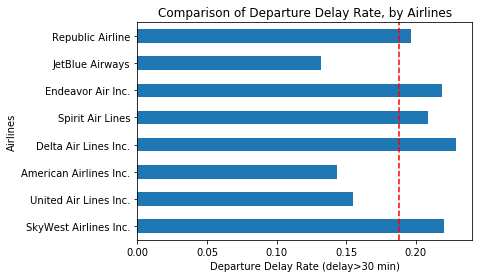

In [9]:
#(2-3) What do delays on this route look like?  
#Plot: departure delay rate, by airlines;
#Real Delay defined as more than "30 minutes", consistent with Question 3's definition; 
routes['dep_delay_flag']=routes['dep_delay']>30 

delay_df=pd.DataFrame(routes.loc[routes.dep_delay_flag==True, 'op_carrier_airline_nm'].value_counts())
delay_df.rename(columns={'op_carrier_airline_nm': 'delay_fl'}, inplace=True)
delay_df['op_carrier_airline_nm']=delay_df.index

_temp=pd.DataFrame(routes['op_carrier_airline_nm'].value_counts())
_temp.rename(columns={'op_carrier_airline_nm': 'total_fl'}, inplace=True)
_temp['op_carrier_airline_nm']=_temp.index

delay_df=delay_df.merge(_temp, left_on='op_carrier_airline_nm', right_on='op_carrier_airline_nm')
delay_df['delay_rate']=delay_df['delay_fl']/delay_df['total_fl']  
delay_df.index=delay_df['op_carrier_airline_nm']    
delay_df['delay_rate'].plot('barh')    
plt.ylabel('Airlines')
plt.xlabel('Departure Delay Rate (delay>30 min)')      
plt.title('Comparison of Departure Delay Rate, by Airlines')    
plt.axvline(delay_df['delay_rate'].mean(), color='r', linestyle='--')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


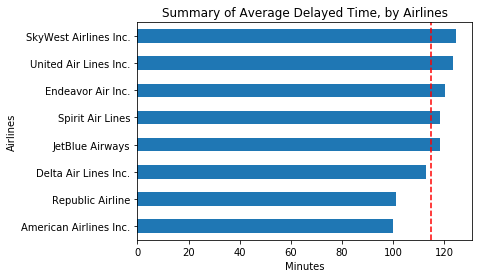

In [10]:
#Table: average delay time (minutes), by airlines;    
avgdly=pd.DataFrame(routes.loc[routes.dep_delay_flag==True, :].groupby('op_carrier_airline_nm')['dep_delay'].mean()).sort_values(by='dep_delay')
avgdly['dep_delay'].plot('barh')  
plt.ylabel('Airlines')
plt.xlabel('Minutes')    
plt.title('Summary of Average Delayed Time, by Airlines')  
plt.axvline(avgdly['dep_delay'].mean(), color='r', linestyle='--')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Summary of Average Delayed Time, by Weekday')

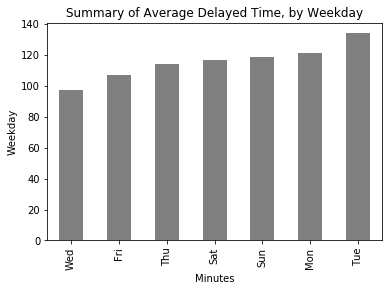

In [11]:
#Table: average delay time (minutes), by workday;        
avgdly2=pd.DataFrame(routes.loc[routes.dep_delay_flag==True, :].groupby('fl_weekday')['dep_delay'].mean()).sort_values(by='dep_delay')
avgdly2['dep_delay'].plot('bar', color='grey')
plt.ylabel('Weekday')
plt.xlabel('Minutes')    
plt.title('Summary of Average Delayed Time, by Weekday')      

In [12]:
#(3) Compare departure delays from the airports from three NYC-area airports.      
routes['dep_delay_flag_2']=routes['dep_delay']>30

#(3-1) delay rate by airport & airline; 
_sub=routes.groupby(['origin_airport_nm', 'op_carrier_airline_nm'])['dep_delay_flag_2'].value_counts()
_sum=_sub.sum(level=[0, 1])
comp=pd.merge(_sub, _sum, left_index=True, right_index=True)  

comp.rename(columns={'dep_delay_flag_2_x': 'num_fl', 'dep_delay_flag_2_y':'total_fl'}, inplace=True)
comp=comp.iloc[comp.index.get_level_values('dep_delay_flag_2') == True]
comp['dep_delay_rate_2']=comp['num_fl']/comp['total_fl']  

comp['index']=comp.index    
comp['origin_airport_nm']=comp['index'].apply(lambda x: x[0])
comp['op_carrier_airline_nm']=comp['index'].apply(lambda x: x[1])  

comp.reset_index(drop=True, inplace=True)  
comp.drop('index', inplace=True, axis=1)   

comp=comp[['origin_airport_nm', "op_carrier_airline_nm", "num_fl", "total_fl", "dep_delay_rate_2"]]  
comp.rename(columns={'origin_airport_nm': 'original airport', 'op_carrier_airline_nm':'airline', 
                    "num_fl": "# of departure-delayed flights", "total_fl": "total flights", 
                    "dep_delay_rate_2":"delayed rate"}, inplace=True)
comp

,original airport,airline,# of departure-delayed flights,total flights,delayed rate
0,John F. Kennedy International,American Airlines Inc.,37,215,0.172093
1,John F. Kennedy International,Endeavor Air Inc.,71,324,0.219136
2,John F. Kennedy International,JetBlue Airways,68,517,0.131528
3,John F. Kennedy International,Republic Airline,2,10,0.200000
4,John F. Kennedy International,SkyWest Airlines Inc.,95,616,0.154221
5,LaGuardia,American Airlines Inc.,380,2701,0.140689
6,LaGuardia,Delta Air Lines Inc.,169,738,0.228997
7,LaGuardia,Republic Airline,52,265,0.196226
8,LaGuardia,SkyWest Airlines Inc.,427,1756,0.243166
9,LaGuardia,Spirit Air Lines,85,408,0.208333


In [13]:
# (3-2) delay rate, only by airport;
a=routes.groupby('origin_airport_nm')['dep_delay_flag_2'].value_counts()
b=a.sum(level=0)
c=pd.merge(a, b, left_index=True, right_index=True)  
c.rename(columns={'dep_delay_flag_2_x': 'num_fl', 'dep_delay_flag_2_y':'total_fl'}, inplace=True)

c=c.iloc[c.index.get_level_values('dep_delay_flag_2') == True]
c['dep_delay_rate_2']=c['num_fl']/c['total_fl']    

c['index']=c.index  
c['origin_airport_nm']=c['index'].apply(lambda x: x[0])  
 
c.reset_index(drop=True, inplace=True)
c.drop('index', inplace=True, axis=1)  

c=c[['origin_airport_nm', "num_fl", "total_fl", "dep_delay_rate_2"]]  
c.rename(columns={'origin_airport_nm': 'original airport', "num_fl": "# of departure-delayed flights", 
                     "total_fl": "total flights", "dep_delay_rate_2":"delayed rate"}, inplace=True)
c    

,original airport,# of departure-delayed flights,total flights,delayed rate
0,John F. Kennedy International,273,1682,0.162307
1,LaGuardia,1537,8603,0.178659


In [14]:
#(3-3) average taxi-out time on runway v.s. delay rate, by airport  
routes.groupby('origin_airport_nm')['taxi_out'].mean()
#Kennedy, bigger airport, lower delay rate, little relevance of delay to runway time;    

origin_airport_nm
John F. Kennedy International    30.204518
LaGuardia                        25.484250
Name: taxi_out, dtype: float64

In [15]:
routes['origin_airport_nm'].value_counts()    
#Kennedy, bigger airport, much fewer flights, data incomplete! 

LaGuardia                        8603
John F. Kennedy International    1682
Name: origin_airport_nm, dtype: int64

In [16]:
#(4) Machine learning model to predict departure delays probability;  
#Data Prep      
nyfl=ny_flights.copy()  
nyfl=nyfl.loc[~nyfl['dep_delay'].isnull(), :]      
nyfl['dep_delay_label']=nyfl['dep_delay']>30    #can tune later if interested;

nyfl['crs_dep_hr']=nyfl['crs_dep_time'].apply(lambda x: int(x[:2]))  
nyfl['crs_arr_hr']=nyfl['crs_arr_time'].apply(lambda x: int(x[:2]))    

#re-code features;   
def hrgroup(hr):
    if hr==24: 
        hr==0
    if 0<=hr<=2:
        return "hr_0_2"
    elif 3<=hr<=5:
        return "hr_3_5"
    elif 6<=hr<=8:
        return "hr_6_8"
    elif 9<=hr<=11:
        return "hr_9_11"
    elif 12<=hr<=14:
        return "hr_12_14"
    elif 15<=hr<=17:
        return "hr_15_17"
    elif 18<=hr<=20:
        return "hr_18_20"
    elif 21<=hr<=23:
        return "hr_21_23"  
    
nyfl['crs_dep_hr_group']=nyfl['crs_dep_hr'].apply(lambda x: hrgroup(x))
nyfl['crs_arr_hr_group']=nyfl['crs_arr_hr'].apply(lambda x: hrgroup(x))
nyfl.drop(['crs_dep_hr', 'crs_arr_hr'], axis=1, inplace=True)

import math
nyfl['log_distance']=nyfl['distance'].apply(lambda x: math.log(x))
nyfl.drop('distance', axis=1, inplace=True)      


#Remove features; 
    #To predict flight delay rate, assuming the flight has NOT occured yet. 
    #Can only include "scheduled" features (NOT "actual" features). 
    #Thus remove features such as air_time, dep_delay etc. below.    
nyfl.drop(['fl_date', 'op_carrier_fl_num', 'wheels_off', 'wheels_on', 'origin_city_market', 'dest_city_market',
           'op_carrier_airline_nm', 'origin_airport_nm', 'dest_airport_nm', 'fl_yr',  
           'crs_dep_time', 'dep_time', 'crs_arr_time', 'arr_time', 'arr_delay', 'actual_elapsed_time',
           'cancelled', 'diverted', 'taxi_in', 'taxi_out', 'air_time', 'dep_delay'],        
          axis=1, inplace=True)        


#One-hot encoding; 
def prepcate(df):      
    scat=['op_carrier_airline_id', 'origin_airport_id', 'origin_city_market_id', 'dest_airport_id',
         'dest_city_market_id', 'fl_weekday', 'fl_mon', 'crs_dep_hr_group', 'crs_arr_hr_group']      
    for i in scat:  
        df[i]=df[i].apply(lambda x: str(x))    
        for j in df[i].unique():    
            df[i+'_'+str(j)]=np.where(df[i]==j, 1, 0)
        df.drop(i, axis=1, inplace=True)            
    return df      
nyfl=prepcate(nyfl) 

In [17]:
#train-test split; 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split        
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score    
Y=nyfl['dep_delay_label']    
X=nyfl.drop('dep_delay_label', axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=1234)     

In [18]:
'''
#Model 1: RandomForest;     
from sklearn.ensemble import RandomForestClassifier

rs=3456
def classifier(classifier, cname, rs):
    model=classifier 
    print('\n')
    print(model)  
    model.fit(xtrain, ytrain)  
    pred=model.predict(xtest)
    tpred=model.predict(xtrain)
   
    print(cname + ' predictions with default hyparameters for Test'+'\n')
    print('Accuracy')
    print(accuracy_score(ytest, pred, normalize=True))
    print(confusion_matrix(ytest, pred))
    print(classification_report(ytest, pred))  
   
    print(cname + ' predictions with default hyparameters for Train'+'\n')
    print('Accuracy')  
    print(accuracy_score(ytrain, tpred, normalize=True)) 

classifier(RandomForestClassifier(random_state=rs, n_estimators=100, class_weight='balanced', 
                                 min_samples_split=2, verbose=0), 'RandomForest', 200) 
'''

"\n#Model 1: RandomForest;     \nfrom sklearn.ensemble import RandomForestClassifier\n\nrs=3456\ndef classifier(classifier, cname, rs):\n    model=classifier \n    print('\n')\n    print(model)  \n    model.fit(xtrain, ytrain)  \n    pred=model.predict(xtest)\n    tpred=model.predict(xtrain)\n   \n    print(cname + ' predictions with default hyparameters for Test'+'\n')\n    print('Accuracy')\n    print(accuracy_score(ytest, pred, normalize=True))\n    print(confusion_matrix(ytest, pred))\n    print(classification_report(ytest, pred))  \n   \n    print(cname + ' predictions with default hyparameters for Train'+'\n')\n    print('Accuracy')  \n    print(accuracy_score(ytrain, tpred, normalize=True)) \n\nclassifier(RandomForestClassifier(random_state=rs, n_estimators=100, class_weight='balanced', \n                                 min_samples_split=2, verbose=0), 'RandomForest', 200) \n"

In [19]:
#Model 2: Lightgbm;      
import lightgbm    
from lightgbm import LGBMClassifier  
lgb_model = LGBMClassifier(boosting_type='gbdt', objective = "binary",
                      metric = "binary_logloss", learning_rate = 0.05,  
                      n_estimators = 20000,
                      subsample_freq = 3, min_child_samples = 5,
                      min_child_weight = 0.1, colsample_bytree = 0.8,
                      subsample = 0.7, min_split_gain = 0.05,
                      max_bin = 25, max_depth = -1,
                      num_leaves = 25, class_weight = 'balanced',     
                      random_state = 3456) 

lgb_model.fit(xtrain, ytrain, eval_set=[(xtest, ytest)], eval_metric="binary_logloss", early_stopping_rounds=100, verbose = 200)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.616777
[400]	valid_0's binary_logloss: 0.611534
[600]	valid_0's binary_logloss: 0.60874
[800]	valid_0's binary_logloss: 0.606413
[1000]	valid_0's binary_logloss: 0.604561
[1200]	valid_0's binary_logloss: 0.602952
[1400]	valid_0's binary_logloss: 0.601297
[1600]	valid_0's binary_logloss: 0.599962
[1800]	valid_0's binary_logloss: 0.598908
[2000]	valid_0's binary_logloss: 0.597994
[2200]	valid_0's binary_logloss: 0.596898
[2400]	valid_0's binary_logloss: 0.595976
[2600]	valid_0's binary_logloss: 0.595323
[2800]	valid_0's binary_logloss: 0.594308
Early stopping, best iteration is:
[2871]	valid_0's binary_logloss: 0.593593


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.8, importance_type='split',
               learning_rate=0.05, max_bin=25, max_depth=-1,
               metric='binary_logloss', min_child_samples=5,
               min_child_weight=0.1, min_split_gain=0.05, n_estimators=20000,
               n_jobs=-1, num_leaves=25, objective='binary', random_state=3456,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=3)

In [20]:
pred_prob=lgb_model.predict(xtest)   
pred=list(pred_prob>=0.5)

tpred_prob=lgb_model.predict(xtrain)  
tpred=list(tpred_prob>=0.5)

print('Lightgbm' + ' predictions with default hyparameters for Test'+'\n')
print('Accuracy')
print(accuracy_score(ytest, pred, normalize=True))
print(confusion_matrix(ytest, pred))
print(classification_report(ytest, pred)) 

print('Lightgbm' + ' predictions with default hyparameters for Train'+'\n')
print('Accuracy')  
print(accuracy_score(ytrain, tpred, normalize=True))     

Lightgbm predictions with default hyparameters for Test

Accuracy
0.6733361643310936
[[137627  66504]
 [ 11960  24107]]
              precision    recall  f1-score   support

       False       0.92      0.67      0.78    204131
        True       0.27      0.67      0.38     36067

    accuracy                           0.67    240198
   macro avg       0.59      0.67      0.58    240198
weighted avg       0.82      0.67      0.72    240198

Lightgbm predictions with default hyparameters for Train

Accuracy
0.6875982450161563


In [21]:
#feature importance from lightgbm model;    
feat={}
for f, i in zip(X.columns, lgb_model.feature_importances_):
    feat[f]=i  
i=pd.DataFrame.from_dict(feat, orient='index')  
#Top 10 important features;         
i.sort_values(by=0, ascending=False).iloc[:10, :]    

,0
crs_elapsed_time,6563
log_distance,2994
fl_weekday_Sun,1481
fl_weekday_Mon,1468
fl_weekday_Tue,1465
fl_weekday_Sat,1447
fl_weekday_Wed,1434
fl_weekday_Thu,1389
fl_weekday_Fri,1356
fl_mon_03,1214


In [22]:
'''  
#Summary;   
#(1) model selection
To predict the flight delay rate, main performance focus here is on f1-score of TRUE class, instead of "overall performance". 
It's preferred for the model to aggressively predict the "True" class, for planning purpose. 

If without using "class_weight='balance' in both RandomFroest and LightGBM models, the overall performance of the model 
seems better, but predict poorly in "TRUE class" (delayed ones) with recall of TRUE class close to 0. 

LightGBM (f1 score for TRUE is 0.38) is preferred over RandomForest (f1 score for TRUE is 0.26) here. 

#(2) Further improve the model  
Precision/recall/F1-score for TRUE class are still low, can be further improved by adding more meaningful features such as 
air traffic volumns, weather conditions. Current features such as airline, airport ID, origin city are too generic to 
provide a high-performing model. 

The explaratory analysis (Question 1) can be improved by more completely reported data, such as more data for each month, 
data volumne of Kenney airport should be more than LaGuardia airport.   

Lassso selection (regularization) is not used here, due to the limited size/volume of features and model performance to improve. 
The model is not over-fitting yet.           
'''

'  \n#Summary;   \n#(1) model selection\nTo predict the flight delay rate, main performance focus here is on f1-score of TRUE class, instead of "overall performance". \nIt\'s preferred for the model to aggressively predict the "True" class, for planning purpose. \n\nIf without using "class_weight=\'balance\' in both RandomFroest and LightGBM models, the overall performance of the model \nseems better, but predict poorly in "TRUE class" (delayed ones) with recall of TRUE class close to 0. \n\nLightGBM (f1 score for TRUE is 0.38) is preferred over RandomForest (f1 score for TRUE is 0.26) here. \n\n#(2) Further improve the model  \nPrecision/recall/F1-score for TRUE class are still low, can be further improved by adding more meaningful features such as \nair traffic volumns, weather conditions. Current features such as airline, airport ID, origin city are too generic to \nprovide a high-performing model. \n\nThe explaratory analysis (Question 1) can be improved by more completely reported

In [1]:
import numpy as np
y=[1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4]
np.bincount(y)

array([0, 1, 3, 1, 6])

In [6]:
array2 = [0, 1, 3, 5, 5, 5, 4, 5, 5, 2, 2, 2] 
bin = np.bincount(array2) 
print("Bincount output  : \n ", bin) 
print("size of bin : ", len(bin), "\n") 

Bincount output  : 
  [1 1 3 1 1 5]
size of bin :  6 



In [8]:
import collections
collections.Counter(array2)

Counter({0: 1, 1: 1, 3: 1, 5: 5, 4: 1, 2: 3})

In [9]:
len(array2)

12

In [10]:
np.bincount(array2)

array([1, 1, 3, 1, 1, 5])